In [7]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep Learning Analysis

In [8]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [9]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [10]:
with open('results/02/results.txt', 'r') as file:
    best_ae_model_path = file.readline().strip()

In [11]:
with open('results/02/best_trial_params.json', 'r') as json_file:
    best_model_params = json.load(json_file)

print(best_model_params)

{'latent_size': 39, 'n_layers': 3, 'dropout': 0.0031343232927195652}


In [12]:
cancer_autoencoder = CancerDataAutoEncoder.load_from_checkpoint(
    best_ae_model_path,
    **best_model_params
)

In [13]:
import random


class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU):
        super(SimpleNN, self).__init__()
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.network(x)

simple_nn = SimpleNN(
    input_dim=best_model_params['latent_size'],
    n_layers=8
)

In [14]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(BaseCancerRegressor(cancer_autoencoder, simple_nn), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCancerRegressor                      [1, 1]                    --
├─CancerDataAutoEncoder: 1-1             --                        88,292
│    └─Sequential: 2-1                   [1, 39]                   --
│    │    └─Linear: 3-1                  [1, 149]                  (30,396)
│    │    └─ReLU: 3-2                    [1, 149]                  --
│    │    └─Dropout: 3-3                 [1, 149]                  --
│    │    └─Linear: 3-4                  [1, 95]                   (14,250)
│    │    └─ReLU: 3-5                    [1, 95]                   --
│    │    └─Dropout: 3-6                 [1, 95]                   --
│    │    └─Linear: 3-7                  [1, 41]                   (3,936)
│    │    └─ReLU: 3-8                    [1, 41]                   --
│    │    └─Dropout: 3-9                 [1, 41]                   --
│    │    └─Linear: 3-10                 [1, 39]                

In [15]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = BaseCancerRegressor(
        cancer_autoencoder,
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=3,
            dropout=.3,
            activation=nn.LeakyReLU,
        ),
        lr=0.003,
        weight_decay=0.004,
        optimizer=torch.optim.Adam,
    )
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 7.3 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [17]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     465.3541259765625     │
│         test_mse          │     426.5283508300781     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 465.3541259765625, 'test_mse': 426.5283508300781}]

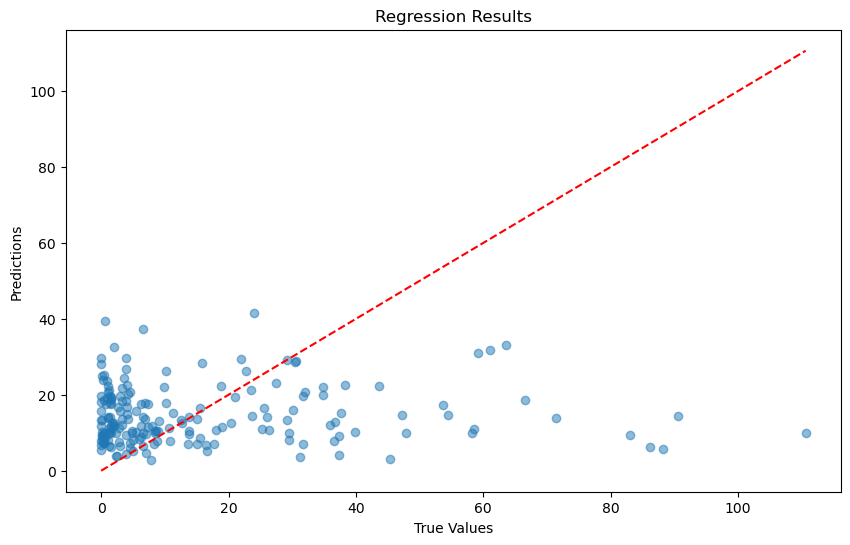

In [18]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = model(x)
            y_true.append(y)
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())

In [19]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 10)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model = BaseCancerRegressor(
        CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=n_layers,
            dropout=dropout,
            activation=activation,
        ),
        lr=learning_rate,
        weight_decay=weight_decay,
        optimizer=optimizer,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", max_epochs=100, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [20]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="regressor_study")
study.optimize(objective, n_trials=50, n_jobs=15, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-14 19:07:44,376] A new study created in memory with name: regressor_study


  0%|          | 0/50 [00:00<?, ?it/s]

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environme

[I 2025-04-14 19:12:03,925] Trial 6 finished with value: 1041.6937255859375 and parameters: {'n_layers': 6, 'dropout': 0.09670005457192615, 'learning_rate': 1.650074379166687e-05, 'weight_decay': 0.001412184501018559, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 6 with value: 1041.6937255859375.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 7.3 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:12:50,819] Trial 5 finished with value: 1024.0880126953125 and parameters: {'n_layers': 5, 'dropout': 0.450831060921652, 'learning_rate': 4.729374631813288e-05, 'weight_decay': 0.000579244398704923, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 5 with value: 1024.0880126953125.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 130 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:14:40,953] Trial 1 finished with value: 1038.436279296875 and parameters: {'n_layers': 4, 'dropout': 0.4245592410127293, 'learning_rate': 5.119375658502065e-05, 'weight_decay': 4.3164763844158954e-05, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 5 with value: 1024.0880126953125.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 31.5 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:17:04,844] Trial 7 finished with value: 721.656982421875 and parameters: {'n_layers': 10, 'dropout': 0.07577578970429016, 'learning_rate': 0.0010926705138919776, 'weight_decay': 0.0008396315470102973, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 7 with value: 721.656982421875.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 522 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:19:21,993] Trial 0 finished with value: 1022.8276977539062 and parameters: {'n_layers': 8, 'dropout': 0.054874797374063033, 'learning_rate': 0.00021654543288641094, 'weight_decay': 0.0004966938111897783, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 7 with value: 721.656982421875.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 131 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:19:40,445] Trial 11 finished with value: 676.6574096679688 and parameters: {'n_layers': 3, 'dropout': 0.34804143041479496, 'learning_rate': 0.0027491932277572133, 'weight_decay': 0.00013722386151781267, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 32.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:25:46,675] Trial 16 finished with value: 707.0446166992188 and parameters: {'n_layers': 6, 'dropout': 0.13531868577591077, 'learning_rate': 0.0009392821724206934, 'weight_decay': 0.00183584331315351, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 7.3 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:26:51,039] Trial 20 finished with value: 1027.8416748046875 and parameters: {'n_layers': 5, 'dropout': 0.10731799757498339, 'learning_rate': 1.0767582442374494e-05, 'weight_decay': 0.0075553857381457385, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 523 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:29:02,279] Trial 12 finished with value: 907.3372802734376 and parameters: {'n_layers': 6, 'dropout': 0.35356213888341415, 'learning_rate': 0.005688128731149061, 'weight_decay': 0.0004110302463760058, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 2.1 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:29:33,674] Trial 19 finished with value: 1037.70263671875 and parameters: {'n_layers': 7, 'dropout': 0.2834930846740978, 'learning_rate': 1.3064279396768707e-05, 'weight_decay': 0.002941121582669838, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 7.3 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:30:10,206] Trial 15 finished with value: 1030.1904296875 and parameters: {'n_layers': 3, 'dropout': 0.27746087995765967, 'learning_rate': 0.0005490667270263871, 'weight_decay': 0.007233002846034109, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 7.3 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:31:46,355] Trial 10 finished with value: 1021.3822021484376 and parameters: {'n_layers': 6, 'dropout': 0.240622045743282, 'learning_rate': 0.0010564313422300746, 'weight_decay': 0.00039592081177212474, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 7.3 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:33:06,890] Trial 9 finished with value: 953.3551025390624 and parameters: {'n_layers': 8, 'dropout': 0.3922775105957536, 'learning_rate': 0.002977386038497762, 'weight_decay': 0.0005194097394009367, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.
[I 2025-04-14 19:33:07,943] Trial 13 finished with value: 853.2557983398438 and parameters: {'n_layers': 6, 'dropout': 0.29661805120272466, 'learning_rate': 8.853536687823976e-05, 'weight_decay': 0.00022351915996008986, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 7.3 K  | train
2 | loss_metric    | MeanSquaredError     

[I 2025-04-14 19:36:55,890] Trial 21 finished with value: 1028.1806640625 and parameters: {'n_layers': 3, 'dropout': 0.21031809584255762, 'learning_rate': 0.00034407211157079406, 'weight_decay': 0.008900923736999336, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 11 with value: 676.6574096679688.
[I 2025-04-14 19:36:58,855] Trial 22 finished with value: 1027.23095703125 and parameters: {'n_layers': 9, 'dropout': 0.036037149304137706, 'learning_rate': 5.593809374193393e-05, 'weight_decay': 0.0001872015893270566, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 31.5 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | Mea

[I 2025-04-14 19:37:36,193] Trial 18 finished with value: 768.2533569335938 and parameters: {'n_layers': 8, 'dropout': 0.19971940671356303, 'learning_rate': 0.00019243027413177796, 'weight_decay': 0.0002558942893283053, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.
[I 2025-04-14 19:37:36,726] Trial 17 finished with value: 1016.7003784179688 and parameters: {'n_layers': 4, 'dropout': 0.4683108611176554, 'learning_rate': 0.001308755853016911, 'weight_decay': 0.006154886623088096, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 31.5 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | Mea

[I 2025-04-14 19:39:14,186] Trial 25 finished with value: 724.569580078125 and parameters: {'n_layers': 3, 'dropout': 0.18986002155589798, 'learning_rate': 0.005007597825505228, 'weight_decay': 7.083267519008988e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 31.5 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:40:12,567] Trial 8 finished with value: 1010.5197143554688 and parameters: {'n_layers': 10, 'dropout': 0.27090494217951044, 'learning_rate': 2.5311439901199125e-05, 'weight_decay': 0.0008632149486666618, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 31.5 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:40:49,235] Trial 27 finished with value: 679.8739013671875 and parameters: {'n_layers': 3, 'dropout': 0.19360299329128322, 'learning_rate': 0.009695951509585705, 'weight_decay': 9.630813196903947e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.
[I 2025-04-14 19:40:49,527] Trial 26 finished with value: 681.197265625 and parameters: {'n_layers': 3, 'dropout': 0.19642959712286598, 'learning_rate': 0.006427636058233716, 'weight_decay': 8.287932980335813e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 31.5 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | Mea

[I 2025-04-14 19:41:28,070] Trial 24 finished with value: 750.207763671875 and parameters: {'n_layers': 3, 'dropout': 0.2259496797931679, 'learning_rate': 0.007445798397529786, 'weight_decay': 5.906322483202344e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 31.5 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:48:38,453] Trial 30 finished with value: 704.8277587890625 and parameters: {'n_layers': 4, 'dropout': 0.16820156530393807, 'learning_rate': 0.0026047343419571233, 'weight_decay': 6.511788181624326e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.
[I 2025-04-14 19:48:38,948] Trial 29 finished with value: 701.2430419921875 and parameters: {'n_layers': 4, 'dropout': 0.16396981975303354, 'learning_rate': 0.009797817870000156, 'weight_decay': 8.877426577908463e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 32.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | Mea

[I 2025-04-14 19:49:01,434] Trial 28 finished with value: 726.2247924804688 and parameters: {'n_layers': 3, 'dropout': 0.19223314052454749, 'learning_rate': 0.007929482401179452, 'weight_decay': 0.0001366457209654737, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.
[I 2025-04-14 19:49:01,993] Trial 31 finished with value: 695.648681640625 and parameters: {'n_layers': 4, 'dropout': 0.15237060364718866, 'learning_rate': 0.009356881875576152, 'weight_decay': 6.686918218810464e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 32.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | Mea

[I 2025-04-14 19:49:31,801] Trial 32 finished with value: 900.00439453125 and parameters: {'n_layers': 4, 'dropout': 0.1437157651842241, 'learning_rate': 0.009613010267890278, 'weight_decay': 6.900554520947222e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 32.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:50:44,350] Trial 36 finished with value: 753.376953125 and parameters: {'n_layers': 4, 'dropout': 0.330452017747152, 'learning_rate': 0.00984893500361005, 'weight_decay': 1.4150605794050193e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 32.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:52:06,949] Trial 34 finished with value: 689.4007568359375 and parameters: {'n_layers': 4, 'dropout': 0.1513297465862046, 'learning_rate': 0.002226993790513997, 'weight_decay': 1.155040814821579e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 32.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:53:03,750] Trial 33 finished with value: 706.5819702148438 and parameters: {'n_layers': 4, 'dropout': 0.15232284420677294, 'learning_rate': 0.008788390211249044, 'weight_decay': 9.710791702580495e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 32.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:54:06,765] Trial 37 finished with value: 679.0839233398438 and parameters: {'n_layers': 4, 'dropout': 0.3408645947442569, 'learning_rate': 0.0025898252289700925, 'weight_decay': 1.2245182766611338e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 32.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:54:57,524] Trial 35 finished with value: 682.496826171875 and parameters: {'n_layers': 4, 'dropout': 0.3273147771649861, 'learning_rate': 0.007507939801019935, 'weight_decay': 0.00010122310613276901, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 32.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:55:09,176] Trial 23 finished with value: 745.2158813476562 and parameters: {'n_layers': 10, 'dropout': 0.3232234677302522, 'learning_rate': 0.0002134383859049987, 'weight_decay': 1.468930895378679e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 32.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:55:21,662] Trial 38 finished with value: 700.6949462890625 and parameters: {'n_layers': 5, 'dropout': 0.33246357362658097, 'learning_rate': 0.0029272998124628717, 'weight_decay': 0.00011909699311421848, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 138 K  | train
1 | neural_network | SimpleNN              | 7.3 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
--------------------

[I 2025-04-14 19:55:50,554] Trial 41 finished with value: 689.9777221679688 and parameters: {'n_layers': 5, 'dropout': 0.339917754387145, 'learning_rate': 0.0031918746176354557, 'weight_decay': 1.785009442783964e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.
[I 2025-04-14 19:56:19,057] Trial 3 finished with value: 1001.1934814453124 and parameters: {'n_layers': 7, 'dropout': 0.44313109441760307, 'learning_rate': 2.1751405558542592e-05, 'weight_decay': 0.0022987061909302466, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 11 with value: 676.6574096679688.
[I 2025-04-14 19:57:10,812] Trial 42 finished with value: 679.732666015625 and parameters: {'n_layers': 5, 'dropout': 0.3316190874864158, 'learning_rate': 0.002765829227732266, 'weight_decay': 1.3369319675697606e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 11 with value: 676.6574096679688.
[I 2025-04-14 19:57:55,631] Trial 43 finished with value: 682.40948486328

In [22]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

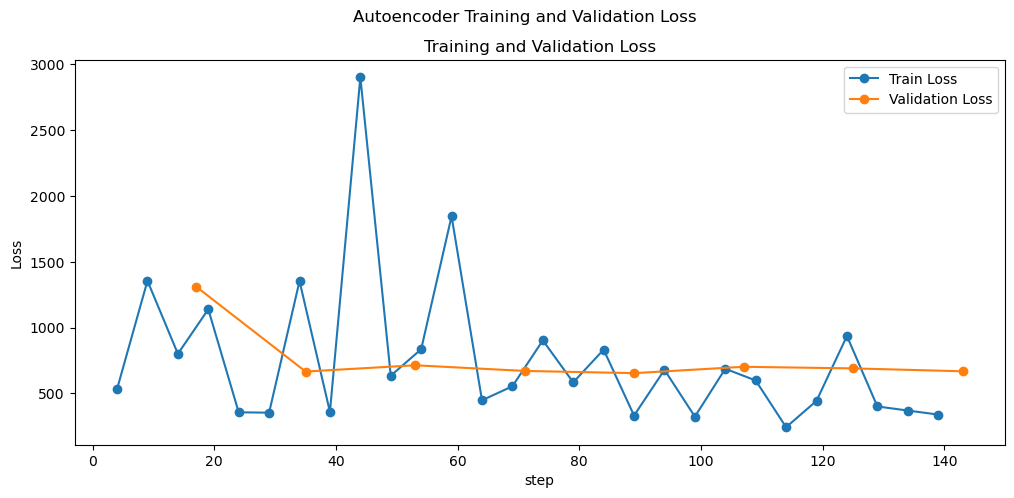

In [ ]:
from utils.helper_functions import make_plots


history = pd.read_csv(best_model_logger.log_dir + "/metrics
make_plots(history, "Autoencoder Training and Validation Loss")

In [29]:
best_model_path = trial_to_details[study.best_trial.number]["checkpoint"].best_model_path
!cp {best_model_path} results/03/best_model.pth

In [ ]:
activation_dict = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "tanh": nn.Tanh,
    "RReLU": nn.RReLU,
}
optimizer_dict = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adagrad": torch.optim.Adagrad,
}

best_model = BaseCancerRegressor.load_from_checkpoint(
    trial_to_details[study.best_trial.number]["checkpoint"].best_model_path,
    auto_encoder=CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        neural_network=SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=study.best_trial.params['n_layers'],
            dropout=study.best_trial.params['dropout'],
            activation=activation_dict[study.best_trial.params['activation']],
        ),
        lr=study.best_trial.params['learning_rate'],
        weight_decay=study.best_trial.params['weight_decay'],
        optimizer=optimizer_dict[study.best_trial.params['optimizer']],
    
)
best_model

BaseCancerRegressor(
  (auto_encoder): CancerDataAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=203, out_features=149, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0031343232927195652, inplace=False)
      (3): Linear(in_features=149, out_features=95, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.0031343232927195652, inplace=False)
      (6): Linear(in_features=95, out_features=41, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.0031343232927195652, inplace=False)
      (9): Linear(in_features=41, out_features=39, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=39, out_features=93, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0031343232927195652, inplace=False)
      (3): Linear(in_features=93, out_features=147, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.0031343232927195652, inplace=False)
      (6): Linear(in_features=147, out_features=201, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.003134323292

: 

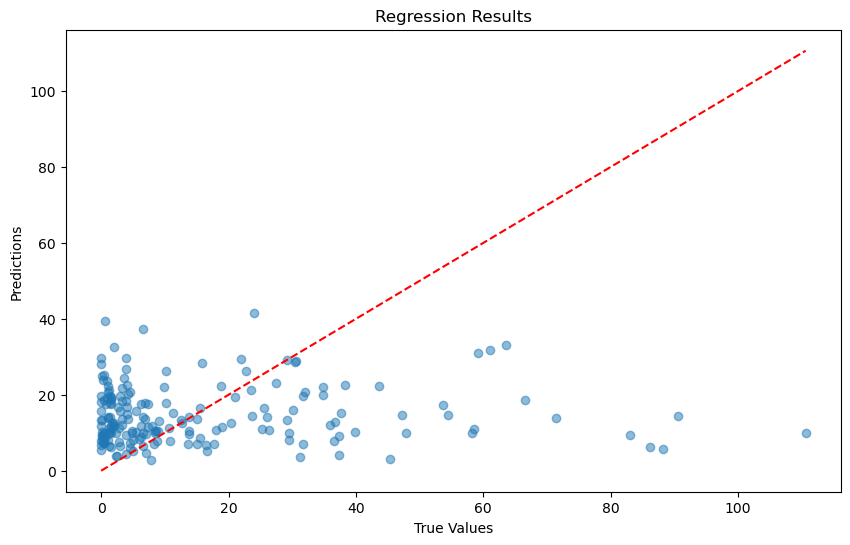

In [28]:
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())